# Oregon's Congressional Apportionment 

*Sabi Horvat, June 2021*

## Context:

1. Refer to [April 2021 article](https://towardsdatascience.com/how-to-draw-congressional-districts-in-python-with-linear-programming-b1e33c80bc52) for information about Congressional Districting and motivation for the model.

2. The June 2021 article (link to be added) focuses on comparing the use of Google's open-source [OR-Tools](https://developers.google.com/optimization/assignment/overview) for solving this model, rather than using PuLP.  For this model, the performance of OR-Tools was much better.

## Model Objective and Constraints:

### Decision Variables

- $\text{assignment}_{i,j} \in [0,1]$: Whether the county [ i ] is assigned to the District [ j ]

- $\text{allocation}_{i,j} \in \mathbb{N}_{0}$: The non-negative amount of population from County [ i ] that is allocated to District [ j ]

### Objective Function

- **Assignments**: Minimize the number of counties assigned to districts

\begin{equation}
\text{Minimize} \quad Z = \sum_{(i,j) \in \text{Counties} \times \text{Districts}}{\text{assignment}_{i,j}}
\end{equation}

> Objective notes: In order to satisfy the constraints, all 36 counties must be assigned.  But counties can be assigned to multiple districts, increasing the upper bound of assignments to [36 counties]*[6 districts] = [216 assignments].  Minimizing the number of assignments while still meeting the constraints ensures that there will not be many counties that are split among multiple districts.  Requiring all counties to be assigned to only one district would make the model infeasible given the constraints to ensure the population of each district is close to equal.

### Constraints

- **Allocate all population**: Each county must have exactly all population allocated to districts.

\begin{equation}
\sum_{j \in \text{Districts}}{\text{assignment}_{i,j}} = \text{county_populations}_{i} \quad \forall i \in \text{Counties}
\end{equation}

- **Assignment required for Allocation**: Allocation can only be greater than zero if assignment is greater than zero. 

\begin{equation}
\sum_{(i,j) \in \text{Counties} \times \text{Districts}} {\text{allocation}_{i,j}} \leq \text{M} \times {\text{assignment}_{i,j}}
\end{equation}

- **Completeness Constraints 2 and 3**: All counties may be assigned to up to 1 district, but only counties with a population of at least 84,000 may be assigned to up to 2 districts. 

\begin{equation}
\text{If }  {\text{county_populations}_{i}} \leq \text{84,000 then }
\sum_{j \in \text{Districts}} {\text{assignment}_{i,j}} \leq \text{1}
\quad \forall i \in \text{Counties}
\end{equation}

\begin{equation}
\text{Else } \sum_{j \in \text{Districts}} {\text{assignment}_{i,j}} \leq \text{2}
\end{equation}

- **Contiguous district constraints**: This constraint exists for each county.  For example, county [ 5 ],  Coos County (5) borders only Curry County (7) or Douglas County (8).  Therefore at least (7) or (8) need to be allocated to any district that has (5).

\begin{equation}
\text{assignment}_{5,j} \leq \text{assignment}_{7,j} + \text{assignment}_{9,j} \forall j \in \text{Districts}
\end{equation}

## Table of Contents for Python Optimization Model
1. Import modules
2. Data analysis on population 
3. Optimization model
4. Review solution and making minor changes as necessary.

In [1]:
import geopandas as gpd 
import numpy as np  
import pandas as pd 
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)

from itertools import product
from pulp import (LpProblem, LpMinimize, LpVariable, lpSum, 
                  PULP_CBC_CMD, GLPK_CMD, LpStatus, value) 
from plotnine import (ggplot, aes, geom_map, geom_text, geom_label, 
                      ggtitle, element_blank, element_rect, 
                      scale_fill_manual, theme_minimal, theme) 

In [2]:
county_id = np.arange(0, 36)
county_names = np.array(['Baker','Benton','Clackamas','Clatsop','Columbia','Coos','Crook','Curry','Deschutes','Douglas','Gilliam','Grant','Harney','Hood River','Jackson','Jefferson','Josephine','Klamath','Lake','Lane','Lincoln','Linn','Malheur','Marion','Morrow','Multnomah','Polk','Sherman','Tillamook','Umatilla','Union','Wallowa','Wasco','Washington','Wheeler','Yamhill']) 
population_by_county = pd.DataFrame({'County_ID': county_id,
                                     'County_Name': county_names,
                                     #2020e from PSU: https://sos.oregon.gov/blue-book/Pages/local/county-population.aspx#InplviewHash04115801-432c-47bf-aef3-abafd774261d=SortField%3DCounty-SortDir%3DAsc
                                     'Population2020e' : [16910,94665,426515,39455,53280,63315,23440,23005,197015,112530,1990,7315,7280,25640,223240,24105,86560,68560,8075,381365,48305,127320,32105,349120,12825,829560,83805,1795,26530,81495,26840,7160,27295,620080,1440,108605],
                                     'Population2010' : [16134,85579,375992,37039,49351,63043,20978,22364,157733,107667,1871,7445,7422,22346,203206,21720,82713,66380,7895,351715,46034,116672,31313,315335,11173,735334,75403,1765,25250,75889,25748,7008,25213,529710,1441,99193],
                                     'Latitude': [44.7346,44.4929,45.3088,46.1068,45.9189,43.175,44.1533,42.6002,43.9856,43.253,45.4204,44.5335,43.2214,45.6007,42.4441,44.4914,42.3351,42.5663,42.7821,44.0123,44.6733,44.4924,43.9454,44.9367,45.4757,45.5437,44.9262,45.4041,45.3957,45.726,45.3181,45.5356,45.3856,45.5404,44.7845,45.2256],
                                     'Longitude': [-117.6777,-123.3844,-122.3999,-123.8773,-122.9863,-124.179,-120.4523,-124.3343,-121.1699,-123.373,-120.2077,-119.0668,-119.0481,-121.7147,-122.7875,-121.3246,-123.5119,-121.6302,-120.4691,-123.1668,-123.9267,-122.7806,-117.484,-122.7301,-119.6694,-122.5346,-123.3237,-120.7307,-123.8622,-118.745,-117.9619,-117.2036,-121.2283,-123.002,-120.02,-123.1982]})
population_by_county['Change2010_2020'] = population_by_county['Population2020e'] - population_by_county['Population2010']

df_county_names = pd.DataFrame(county_names, columns = ['County'])
df = pd.DataFrame()
df['County']  = county_names
df['CountySort'] = county_id

shapefile_oregon = gpd.read_file('data/orcounty.shp')
map_population_by_county_data = shapefile_oregon.merge(population_by_county, left_on='NAME', right_on='County_Name',suffixes=('_left', '_right'))
county_populations = np.array(population_by_county['Population2020e'])
state_population = sum(county_populations)
population_by_county.sort_values('Population2020e', ascending=False).head()

,County_ID,County_Name,Population2020e,Population2010,Latitude,Longitude,Change2010_2020
25,25,Multnomah,829560,735334,45.5437,-122.5346,94226
33,33,Washington,620080,529710,45.5404,-123.0020,90370
2,2,Clackamas,426515,375992,45.3088,-122.3999,50523
19,19,Lane,381365,351715,44.0123,-123.1668,29650
23,23,Marion,349120,315335,44.9367,-122.7301,33785


In [3]:
n_counties = 36
n_districts = 6
variable_names = [str(i)+str(j) for j in range(1, n_districts+1) \
                                for i in range(1, n_counties+1)]
variable_names.sort() 

## Optimization Model

In [4]:
# Set parameters for the model
population_split = 220000
min_dist = 700000
max_dist = 720000

In [5]:
# Create the model and choose whether to minimize or maximize
model = LpProblem("Supply-Demand-Problem", LpMinimize) 

# Declare Variables
# The Decision Variable is 1 if the county is assigned to the district.
DV_variable_y = LpVariable.matrix("Y", variable_names, cat="Binary")
assignment = np.array(DV_variable_y).reshape(36,6)

# The Decision Variable is the population allocated to the district.
DV_variable_x = LpVariable.matrix("X", variable_names, cat="Integer",
                                  lowBound=0)
allocation = np.array(DV_variable_x).reshape(36,6)    

# Write the objective 
objective_function = lpSum(assignment) 
model += objective_function

In [6]:
# Constraints

# Allocate 100% of the population from each county.
for i in range(n_counties):
    model += lpSum(allocation[i][j] for j in range(n_districts)) == county_populations[i] , "Allocate All " + str(i)
    
# This constraint makes assignment required for allocation.
# sum(county_populations) is the "big M"
for i in range(n_counties): 
    for j in range(n_districts):
        model += allocation[i][j] <= sum(county_populations)*assignment[i][j] , "Allocation assignment " + str(i) + str(j)

In [7]:
# Contiguous districts constraints
# e.g. Coos County (5) borders only Curry County (7) or Douglas County (8)
#      Therefore at least (7) or (8) need to be allocated to any district that has (5)
# Optionally, add `2*` to the left hand side so that the county is required to border at least two counties from the same district
for j in range(n_districts):
    model += assignment[0][j] <= assignment[11][j]+assignment[22][j]+assignment[30][j]+assignment[31][j]  
    model += assignment[1][j] <= assignment[19][j]+assignment[20][j]+assignment[21][j]+assignment[26][j] 
    model += assignment[2][j] <= assignment[13][j]+assignment[23][j]+assignment[25][j]+assignment[32][j]+assignment[33][j]+assignment[35][j]
    model += assignment[3][j] <= assignment[4][j]+assignment[28][j] 
    model += assignment[4][j] <= assignment[3][j]+assignment[25][j]+assignment[33][j]
    model += assignment[5][j] <= assignment[7][j]+assignment[9][j] 
    model += assignment[6][j] <= assignment[8][j]+assignment[11][j]+assignment[12][j]+assignment[15][j]+assignment[34][j]
    model += assignment[7][j] <= assignment[5][j]+assignment[9][j]+assignment[16][j] 
    model += assignment[8][j] <= assignment[6][j]+assignment[12][j]+assignment[15][j]+assignment[17][j]+assignment[18][j]+assignment[19][j]+assignment[21][j]
    model += assignment[9][j] <= assignment[5][j]+assignment[7][j]+assignment[14][j]+assignment[16][j]+assignment[17][j]+assignment[19][j]
    model += assignment[10][j] <= assignment[24][j]+assignment[27][j]+assignment[32][j]+assignment[34][j]
    model += assignment[11][j] <= assignment[0][j]+assignment[6][j]+assignment[12][j]+assignment[22][j]+assignment[24][j]+assignment[29][j]+assignment[30][j]+assignment[34][j]
    model += assignment[12][j] <= assignment[6][j]+assignment[8][j]+assignment[11][j]+assignment[18][j]+assignment[22][j]
    model += assignment[13][j] <= assignment[2][j]+assignment[25][j]+assignment[32][j]
    model += assignment[14][j] <= assignment[9][j]+assignment[16][j]+assignment[17][j]
    model += assignment[15][j] <= assignment[6][j]+assignment[8][j]+assignment[21][j]+assignment[23][j]+assignment[32][j]+assignment[34][j]
    model += assignment[16][j] <= assignment[7][j]+assignment[9][j]+assignment[14][j]
    model += assignment[17][j] <= assignment[8][j]+assignment[9][j]+assignment[14][j]+assignment[18][j]+assignment[19][j]
    model += assignment[18][j] <= assignment[8][j]+assignment[12][j]+assignment[17][j]
    model += assignment[19][j] <= assignment[1][j]+assignment[8][j]+assignment[9][j]+assignment[17][j]+assignment[20][j]+assignment[21][j]
    model += assignment[20][j] <= assignment[1][j]+assignment[19][j]+assignment[26][j]+assignment[28][j]
    model += assignment[21][j] <= assignment[1][j]+assignment[8][j]+assignment[15][j]+assignment[19][j]+assignment[23][j]+assignment[26][j] 
    model += assignment[22][j] <= assignment[0][j]+assignment[11][j]+assignment[12][j]
    model += assignment[23][j] <= assignment[2][j]+assignment[15][j]+assignment[21][j]+assignment[26][j]+assignment[32][j]+assignment[35][j]
    model += assignment[24][j] <= assignment[10][j]+assignment[11][j]+assignment[29][j]+assignment[34][j]
    model += assignment[25][j] <= assignment[2][j]+assignment[4][j]+assignment[13][j]+assignment[33][j]
    model += assignment[26][j] <= assignment[1][j]+assignment[20][j]+assignment[21][j]+assignment[23][j]+assignment[28][j]+assignment[35][j]
    model += assignment[27][j] <= assignment[10][j]+assignment[32][j]
    model += assignment[28][j] <= assignment[3][j]+assignment[20][j]+assignment[26][j]+assignment[33][j]+assignment[35][j]
    model += assignment[29][j] <= assignment[11][j]+assignment[24][j]+assignment[30][j]+assignment[31][j]
    model += assignment[30][j] <= assignment[0][j]+assignment[11][j]+assignment[29][j]+assignment[31][j]
    model += assignment[31][j] <= assignment[0][j]+assignment[29][j]+assignment[30][j]
    model += assignment[32][j] <= assignment[2][j]+assignment[10][j]+assignment[13][j]+assignment[15][j]+assignment[23][j]+assignment[27][j]+assignment[34][j]
    model += assignment[33][j] <= assignment[2][j]+assignment[4][j]+assignment[25][j]+assignment[28][j]+assignment[35][j]
    model += assignment[34][j] <= assignment[6][j]+assignment[10][j]+assignment[11][j]+assignment[15][j]+assignment[24][j]+assignment[32][j]
    model += assignment[35][j] <= assignment[2][j]+assignment[23][j]+assignment[26][j]+assignment[28][j]+assignment[33][j]
    

In [8]:
sum(county_populations)/6

711423.3333333334

In [9]:
# District size constraints, in order to keep the size of districts by population similar
for j in range(n_districts):
    model += lpSum(allocation[i][j] for i in range(n_counties)) <= max_dist , "District Size Maximum " + str(j)
    model += lpSum(allocation[i][j] for i in range(n_counties)) >= min_dist , "District Size Minimum " + str(j)


In [10]:
# Only allow counties that meet certain critera to be split among multiple districts
# A county must have population > population_split to be split among up to two districts
for i in range(n_counties): # added
    if county_populations[i] <= population_split: 
        model += lpSum(assignment[i][j] for j in range(n_districts)) <= 1  , "Unique Assignment " + str(i) 
    else:
        model += lpSum(assignment[i][j] for j in range(n_districts)) <= 2  , "Up-to-two Assignments " + str(i)

In [11]:
# Improvement Assignment / Allocation Constraints (sometimes known as cuts)

# pairs of counties that are far apart geographically with population centers in between them
for j in range(n_districts):
    # East counties not to be assigned to the west beyond population centers in the middle
    # 0, 11, 12, 22, 24, 29, 30, 31
    # Baker (0) on the east not to be assigned to the west beyond population centers in the middle
    model += assignment[0][j] + assignment[1][j] <= 1 
    model += assignment[0][j] + assignment[3][j] <= 1 
    model += assignment[0][j] + assignment[4][j] <= 1 
    model += assignment[0][j] + assignment[5][j] <= 1 
    model += assignment[0][j] + assignment[6][j] <= 1 
    model += assignment[0][j] + assignment[19][j] <= 1 
    model += assignment[0][j] + assignment[20][j] <= 1 
    model += assignment[0][j] + assignment[21][j] <= 1 
    model += assignment[0][j] + assignment[23][j] <= 1 
    model += assignment[0][j] + assignment[25][j] <= 1 
    model += assignment[0][j] + assignment[26][j] <= 1 
    model += assignment[0][j] + assignment[28][j] <= 1 
    model += assignment[0][j] + assignment[33][j] <= 1 
    model += assignment[0][j] + assignment[35][j] <= 1 
    # same with Grant (11)
    model += assignment[11][j] + assignment[1][j] <= 1 
    model += assignment[11][j] + assignment[3][j] <= 1 
    model += assignment[11][j] + assignment[4][j] <= 1 
    model += assignment[11][j] + assignment[5][j] <= 1 
    model += assignment[11][j] + assignment[6][j] <= 1 
    model += assignment[11][j] + assignment[19][j] <= 1
    model += assignment[11][j] + assignment[20][j] <= 1
    model += assignment[11][j] + assignment[21][j] <= 1
    model += assignment[11][j] + assignment[23][j] <= 1
    model += assignment[11][j] + assignment[25][j] <= 1
    model += assignment[11][j] + assignment[26][j] <= 1
    model += assignment[11][j] + assignment[28][j] <= 1
    model += assignment[11][j] + assignment[33][j] <= 1
    model += assignment[11][j] + assignment[35][j] <= 1
    # same with Harney (12)
    model += assignment[12][j] + assignment[1][j] <= 1 
    model += assignment[12][j] + assignment[3][j] <= 1 
    model += assignment[12][j] + assignment[4][j] <= 1 
    model += assignment[12][j] + assignment[5][j] <= 1 
    model += assignment[12][j] + assignment[6][j] <= 1 
    model += assignment[12][j] + assignment[19][j] <= 1
    model += assignment[12][j] + assignment[20][j] <= 1
    model += assignment[12][j] + assignment[21][j] <= 1
    model += assignment[12][j] + assignment[23][j] <= 1
    model += assignment[12][j] + assignment[25][j] <= 1
    model += assignment[12][j] + assignment[26][j] <= 1
    model += assignment[12][j] + assignment[28][j] <= 1
    model += assignment[12][j] + assignment[33][j] <= 1
    model += assignment[12][j] + assignment[35][j] <= 1
    # same with Malheur (22)
    model += assignment[22][j] + assignment[1][j] <= 1 
    model += assignment[22][j] + assignment[3][j] <= 1 
    model += assignment[22][j] + assignment[4][j] <= 1 
    model += assignment[22][j] + assignment[5][j] <= 1 
    model += assignment[22][j] + assignment[6][j] <= 1 
    model += assignment[22][j] + assignment[19][j] <= 1
    model += assignment[22][j] + assignment[20][j] <= 1
    model += assignment[22][j] + assignment[21][j] <= 1
    model += assignment[22][j] + assignment[23][j] <= 1
    model += assignment[22][j] + assignment[25][j] <= 1
    model += assignment[22][j] + assignment[26][j] <= 1
    model += assignment[22][j] + assignment[28][j] <= 1
    model += assignment[22][j] + assignment[33][j] <= 1
    model += assignment[22][j] + assignment[35][j] <= 1
    # same with Morrow (24)
    model += assignment[24][j] + assignment[1][j] <= 1 
    model += assignment[24][j] + assignment[3][j] <= 1 
    model += assignment[24][j] + assignment[4][j] <= 1 
    model += assignment[24][j] + assignment[5][j] <= 1 
    model += assignment[24][j] + assignment[6][j] <= 1 
    model += assignment[24][j] + assignment[19][j] <= 1
    model += assignment[24][j] + assignment[20][j] <= 1
    model += assignment[24][j] + assignment[21][j] <= 1
    model += assignment[24][j] + assignment[23][j] <= 1
    model += assignment[24][j] + assignment[25][j] <= 1
    model += assignment[24][j] + assignment[26][j] <= 1
    model += assignment[24][j] + assignment[28][j] <= 1
    model += assignment[24][j] + assignment[33][j] <= 1
    model += assignment[24][j] + assignment[35][j] <= 1
    # same with Umatilla (29)
    model += assignment[29][j] + assignment[1][j] <= 1 
    model += assignment[29][j] + assignment[3][j] <= 1 
    model += assignment[29][j] + assignment[4][j] <= 1 
    model += assignment[29][j] + assignment[5][j] <= 1 
    model += assignment[29][j] + assignment[6][j] <= 1 
    model += assignment[29][j] + assignment[19][j] <= 1
    model += assignment[29][j] + assignment[20][j] <= 1
    model += assignment[29][j] + assignment[21][j] <= 1
    model += assignment[29][j] + assignment[23][j] <= 1
    model += assignment[29][j] + assignment[25][j] <= 1
    model += assignment[29][j] + assignment[26][j] <= 1
    model += assignment[29][j] + assignment[28][j] <= 1
    model += assignment[29][j] + assignment[33][j] <= 1
    model += assignment[29][j] + assignment[35][j] <= 1
    # same with Union (30)
    model += assignment[30][j] + assignment[1][j] <= 1 
    model += assignment[30][j] + assignment[3][j] <= 1 
    model += assignment[30][j] + assignment[4][j] <= 1 
    model += assignment[30][j] + assignment[5][j] <= 1 
    model += assignment[30][j] + assignment[6][j] <= 1 
    model += assignment[30][j] + assignment[19][j] <= 1
    model += assignment[30][j] + assignment[20][j] <= 1
    model += assignment[30][j] + assignment[21][j] <= 1
    model += assignment[30][j] + assignment[23][j] <= 1
    model += assignment[30][j] + assignment[25][j] <= 1
    model += assignment[30][j] + assignment[26][j] <= 1
    model += assignment[30][j] + assignment[28][j] <= 1
    model += assignment[30][j] + assignment[33][j] <= 1
    model += assignment[30][j] + assignment[35][j] <= 1
    # same with Wallowa (31)
    model += assignment[31][j] + assignment[1][j] <= 1 
    model += assignment[31][j] + assignment[3][j] <= 1 
    model += assignment[31][j] + assignment[4][j] <= 1 
    model += assignment[31][j] + assignment[5][j] <= 1 
    model += assignment[31][j] + assignment[6][j] <= 1 
    model += assignment[31][j] + assignment[19][j] <= 1 
    model += assignment[31][j] + assignment[20][j] <= 1 
    model += assignment[31][j] + assignment[21][j] <= 1 
    model += assignment[31][j] + assignment[23][j] <= 1 
    model += assignment[31][j] + assignment[25][j] <= 1 
    model += assignment[31][j] + assignment[26][j] <= 1 
    model += assignment[31][j] + assignment[28][j] <= 1 
    model += assignment[31][j] + assignment[33][j] <= 1 
    model += assignment[31][j] + assignment[35][j] <= 1 
    # southwest counties (5,6,9,19) shouldn't be in the same district as north counties
    # Coos County (5)
    model += assignment[5][j] + assignment[3][j] <= 1
    model += assignment[5][j] + assignment[4][j] <= 1
    model += assignment[5][j] + assignment[6][j] <= 1
    model += assignment[5][j] + assignment[10][j] <= 1
    model += assignment[5][j] + assignment[11][j] <= 1
    model += assignment[5][j] + assignment[13][j] <= 1
    model += assignment[5][j] + assignment[15][j] <= 1
    model += assignment[5][j] + assignment[24][j] <= 1
    model += assignment[5][j] + assignment[27][j] <= 1
    model += assignment[5][j] + assignment[28][j] <= 1
    model += assignment[5][j] + assignment[32][j] <= 1
    model += assignment[5][j] + assignment[34][j] <= 1
    # Curry County (7)
    model += assignment[7][j] + assignment[3][j] <= 1
    model += assignment[7][j] + assignment[4][j] <= 1
    model += assignment[7][j] + assignment[6][j] <= 1
    model += assignment[7][j] + assignment[10][j] <= 1
    model += assignment[7][j] + assignment[11][j] <= 1
    model += assignment[7][j] + assignment[13][j] <= 1
    model += assignment[7][j] + assignment[15][j] <= 1
    model += assignment[7][j] + assignment[24][j] <= 1
    model += assignment[7][j] + assignment[27][j] <= 1
    model += assignment[7][j] + assignment[28][j] <= 1
    model += assignment[7][j] + assignment[32][j] <= 1
    model += assignment[7][j] + assignment[34][j] <= 1
    # Douglas County (9)
    model += assignment[9][j] + assignment[3][j] <= 1
    model += assignment[9][j] + assignment[4][j] <= 1
    model += assignment[9][j] + assignment[6][j] <= 1
    model += assignment[6][j] + assignment[10][j] <= 1
    model += assignment[9][j] + assignment[11][j] <= 1
    model += assignment[9][j] + assignment[13][j] <= 1
    model += assignment[9][j] + assignment[15][j] <= 1
    model += assignment[9][j] + assignment[24][j] <= 1
    model += assignment[9][j] + assignment[27][j] <= 1
    model += assignment[9][j] + assignment[28][j] <= 1
    model += assignment[9][j] + assignment[32][j] <= 1
    model += assignment[9][j] + assignment[34][j] <= 1
    # Lane County (19)
    model += assignment[19][j] + assignment[3][j] <= 1
    model += assignment[19][j] + assignment[4][j] <= 1
    model += assignment[19][j] + assignment[6][j] <= 1
    model += assignment[19][j] + assignment[10][j] <= 1
    model += assignment[19][j] + assignment[11][j] <= 1
    model += assignment[19][j] + assignment[13][j] <= 1
    model += assignment[19][j] + assignment[15][j] <= 1
    model += assignment[19][j] + assignment[24][j] <= 1
    model += assignment[19][j] + assignment[27][j] <= 1
    model += assignment[19][j] + assignment[28][j] <= 1
    model += assignment[19][j] + assignment[32][j] <= 1
    model += assignment[19][j] + assignment[34][j] <= 1
    # northwest counties (3,4,28) shouldn't be in the same district as counties on other side of population centers
    model += assignment[3][j] + assignment[1][j] <= 1
    model += assignment[3][j] + assignment[6][j] <= 1
    model += assignment[3][j] + assignment[8][j] <= 1
    model += assignment[3][j] + assignment[10][j] <= 1
    model += assignment[3][j] + assignment[21][j] <= 1
    model += assignment[3][j] + assignment[27][j] <= 1
    model += assignment[4][j] + assignment[1][j] <= 1
    model += assignment[4][j] + assignment[6][j] <= 1
    model += assignment[4][j] + assignment[8][j] <= 1
    model += assignment[4][j] + assignment[10][j] <= 1
    model += assignment[4][j] + assignment[21][j] <= 1
    model += assignment[4][j] + assignment[27][j] <= 1
    model += assignment[28][j] + assignment[1][j] <= 1
    model += assignment[28][j] + assignment[6][j] <= 1
    model += assignment[28][j] + assignment[8][j] <= 1
    model += assignment[28][j] + assignment[10][j] <= 1
    model += assignment[28][j] + assignment[21][j] <= 1
    model += assignment[28][j] + assignment[27][j] <= 1
    # multnomah (25)
    model += assignment[5][j] + assignment[25][j] <= 1 
    model += assignment[6][j] + assignment[25][j] <= 1 
    model += assignment[7][j] + assignment[25][j] <= 1 
    model += assignment[9][j] + assignment[25][j] <= 1 
    model += assignment[10][j] + assignment[25][j] <= 1
    model += assignment[16][j] + assignment[25][j] <= 1
    model += assignment[17][j] + assignment[25][j] <= 1
    model += assignment[18][j] + assignment[25][j] <= 1
    model += assignment[19][j] + assignment[25][j] <= 1
    model += assignment[20][j] + assignment[25][j] <= 1
    model += assignment[21][j] + assignment[25][j] <= 1
    model += assignment[23][j] + assignment[25][j] <= 1
    model += assignment[26][j] + assignment[25][j] <= 1
    model += assignment[27][j] + assignment[25][j] <= 1
    model += assignment[28][j] + assignment[25][j] <= 1
    model += assignment[34][j] + assignment[25][j] <= 1
    # clackamas (2) 
    model += assignment[2][j] + assignment[5][j] <= 1 
    # these constraints from practice iterations
    model += assignment[1][j] + assignment[6][j] <= 1
    model += assignment[1][j] + assignment[34][j] <= 1
    model += assignment[3][j] + assignment[32][j] <= 1 
    model += assignment[3][j] + assignment[34][j] <= 1 
    model += assignment[4][j] + assignment[22][j] <= 1 
    model += assignment[4][j] + assignment[32][j] <= 1 
    model += assignment[4][j] + assignment[34][j] <= 1 
    model += assignment[7][j] + assignment[33][j] <= 1 
    model += assignment[8][j] + assignment[26][j] <= 1 
    model += assignment[8][j] + assignment[28][j] <= 1 
    model += assignment[8][j] + assignment[33][j] <= 1 
    model += assignment[9][j] + assignment[28][j] <= 1 
    model += assignment[9][j] + assignment[33][j] <= 1 
    model += assignment[10][j] + assignment[28][j] <= 1
    model += assignment[14][j] + assignment[28][j] <= 1 
    model += assignment[14][j] + assignment[33][j] <= 1 
    model += assignment[16][j] + assignment[21][j] <= 1 
    model += assignment[16][j] + assignment[33][j] <= 1 
    model += assignment[17][j] + assignment[23][j] <= 1 
    model += assignment[17][j] + assignment[26][j] <= 1 
    model += assignment[17][j] + assignment[33][j] <= 1 
    model += assignment[18][j] + assignment[23][j] <= 1 
    model += assignment[18][j] + assignment[26][j] <= 1     
    model += assignment[18][j] + assignment[28][j] <= 1 
    model += assignment[18][j] + assignment[33][j] <= 1 
    model += assignment[24][j] + assignment[28][j] <= 1 
    model += assignment[28][j] + assignment[29][j] <= 1 

In [12]:
# Solve the model
# !glpsol --help # for details on solver parameters
model.solve(GLPK_CMD(options=["--mipgap", "0.055", "--gomory"])) 
#model.solve() # Default solver is CBC
#model.solve(GLPK_CMD()) 

1

In [14]:
print('The model status is: ',LpStatus[model.status])
print('The objective value is: ', value(objective_function))

# print('Total counties = ', solver.Objective().Value())

The model status is:  Optimal
The objective value is:  39


In [15]:
# Access the results
for i in range(n_counties):
    for j in range(n_districts):
        if allocation[i][j].value() > 0:
            print('County %d assigned to district %d: ' % (i, j), allocation[i][j].value())

County 0 assigned to district 2:  16910
County 1 assigned to district 3:  94665
County 2 assigned to district 5:  426515
County 3 assigned to district 1:  39455
County 4 assigned to district 0:  53280
County 5 assigned to district 3:  63315
County 6 assigned to district 5:  23440
County 7 assigned to district 3:  23005
County 8 assigned to district 2:  197015
County 9 assigned to district 3:  112530
County 10 assigned to district 2:  1990
County 11 assigned to district 2:  7315
County 12 assigned to district 2:  7280
County 13 assigned to district 5:  25640
County 14 assigned to district 2:  198120
County 14 assigned to district 3:  25120
County 15 assigned to district 5:  24105
County 16 assigned to district 2:  86560
County 17 assigned to district 5:  68560
County 18 assigned to district 5:  8075
County 19 assigned to district 3:  381365
County 20 assigned to district 1:  48305
County 21 assigned to district 5:  127320
County 22 assigned to district 2:  32105
County 23 assigned to di

## Create Maps

In [16]:
# Access the results
for i in range(n_counties):
    for j in range(n_districts):
        if allocation[i][j].value() > 0:
            print('County %d assigned to district %d: ' % (i, j), allocation[i][j].value())

County 0 assigned to district 2:  16910
County 1 assigned to district 3:  94665
County 2 assigned to district 5:  426515
County 3 assigned to district 1:  39455
County 4 assigned to district 0:  53280
County 5 assigned to district 3:  63315
County 6 assigned to district 5:  23440
County 7 assigned to district 3:  23005
County 8 assigned to district 2:  197015
County 9 assigned to district 3:  112530
County 10 assigned to district 2:  1990
County 11 assigned to district 2:  7315
County 12 assigned to district 2:  7280
County 13 assigned to district 5:  25640
County 14 assigned to district 2:  198120
County 14 assigned to district 3:  25120
County 15 assigned to district 5:  24105
County 16 assigned to district 2:  86560
County 17 assigned to district 5:  68560
County 18 assigned to district 5:  8075
County 19 assigned to district 3:  381365
County 20 assigned to district 1:  48305
County 21 assigned to district 5:  127320
County 22 assigned to district 2:  32105
County 23 assigned to di

In [17]:
# Prepare data for visualizing the results
result_value = []
for i in range(n_counties):
    for j in range(n_districts):
        var_output = {
            'County': i,
            'District': j+1,
            'Assignment': int(assignment[i][j].value()*(j+1)),
            'Allocation': allocation[i][j].value()}
        result_value.append(var_output)
        
results = pd.DataFrame(result_value)
results = results[results['Assignment'] != 0]
results = results.sort_values(['County', 'District'])
results = results.merge(df, left_on='County', right_on='CountySort',suffixes=('_ID', '_Name'))
results['Multiple_County_Name'] = results['County_Name'].shift(periods=1)
results['Multiple_District'] = results['District'].shift(periods=1).fillna(99).astype(int)

# Edit the assignment for the case when a county has multiple assignments 
for i in range(0,len(results)):
    if results['County_Name'].loc[i] == results['Multiple_County_Name'].loc[i]:
        results.loc[i, 'Assignment'] =   int(str(results['District'].loc[i]) + \
                                                        str(results['Multiple_District'].loc[i]))
results = results.sort_values(['District','County_Name'])
results.index = results['County_ID']

In [18]:
color_dict = { 1 : 'khaki',
               2 : 'pink',
               3 : 'mediumaquamarine',
               4 : 'plum',
               5 : 'paleturquoise',
               6 : 'lightcoral',
               12: 'grey', 13: 'grey', 14: 'grey', 15: 'grey', 16: 'grey',
               21: 'grey', 23: 'grey', 24: 'grey', 25: 'grey', 26: 'grey',
               31: 'grey', 32: 'grey', 34: 'grey', 35: 'grey', 36: 'grey',
               41: 'grey', 42: 'grey', 43: 'grey', 45: 'grey', 46: 'grey',
               51: 'grey', 52: 'grey', 53: 'grey', 54: 'grey', 56: 'grey',
               61: 'grey', 62: 'grey', 63: 'grey', 64: 'grey', 65: 'grey'}

def oregon_map(map_data):
    """
    Create three maps to visualize the results.  
    (1) A map with population labels
    (2) A map with county labels
    (3) A map with county IDs
    """
    
    plot_map_population_labels = (
        ggplot(map_data)
    + geom_map(aes(fill=str('Assignment'))) 
    + geom_label(aes(x='Longitude', y='Latitude', label='Population2020e', size=2), 
                 show_legend=False)
    + theme_minimal()
    + theme(axis_text_x=element_blank(),
            axis_text_y=element_blank(),
            axis_title_x=element_blank(),
            axis_title_y=element_blank(),
            axis_ticks=element_blank(),
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            figure_size=(7, 4))
    + scale_fill_manual(values=color_dict))
    
    plot_map_county_labels = (
        ggplot(map_data)
    + geom_map(aes(fill=str('Assignment'))) 
    + geom_label(aes(x='Longitude', y='Latitude', label='County_Name_left', size=2), 
                 show_legend=False)
    + theme_minimal()
    + theme(axis_text_x=element_blank(),
            axis_text_y=element_blank(),
            axis_title_x=element_blank(),
            axis_title_y=element_blank(),
            axis_ticks=element_blank(),
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            figure_size=(7, 4))
    + scale_fill_manual(values=color_dict))
    
    plot_map_county_ids = (
        ggplot(map_data)
    + geom_map(aes(fill=str('Assignment'))) 
    + geom_label(aes(x='Longitude', y='Latitude', label='County_ID', size=5), 
                 show_legend=False)
    + theme_minimal()
    + theme(axis_text_x=element_blank(),
            axis_text_y=element_blank(),
            axis_title_x=element_blank(),
            axis_title_y=element_blank(),
            axis_ticks=element_blank(),
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            figure_size=(7, 4))
    + scale_fill_manual(values=color_dict))
    
    return plot_map_population_labels, plot_map_county_labels, plot_map_county_ids


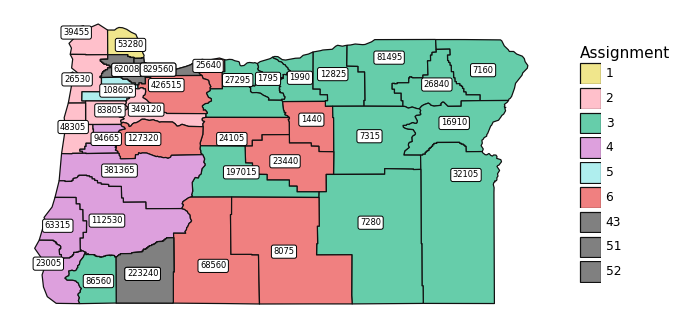

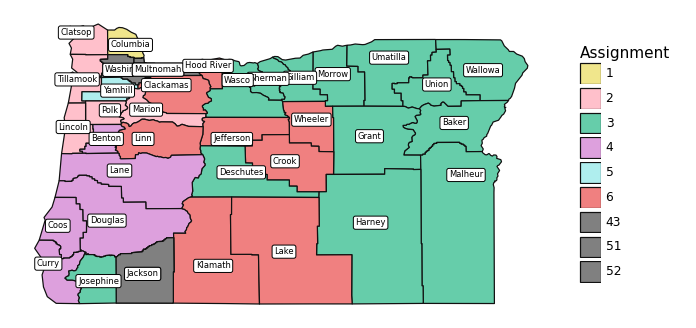

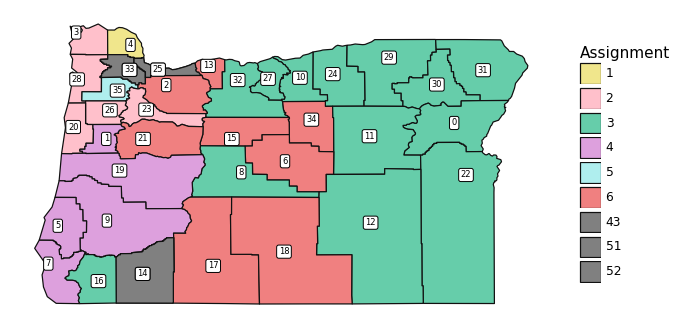

(<ggplot: (8786521985145)>,
 <ggplot: (8786521851242)>,
 <ggplot: (8786521901550)>)

In [19]:
map_first_pass = shapefile_oregon.merge(results, left_on='NAME', right_on='County_Name',suffixes=('_left', '_right'))
map_first_pass['District'] = map_first_pass['District']+1
map_first_pass_labels = map_first_pass.merge(population_by_county, left_on='County_ID', right_on='County_ID',suffixes=('_left','_right'))
map_first_pass_labels['District'] = map_first_pass_labels['District'].astype('category')
map_first_pass_labels['Assignment'] = map_first_pass_labels['Assignment'].astype("category")

oregon_map(map_first_pass_labels)

In [20]:
# Display DataFrame of Counties in Multiple Districts
results[['County_Name','District','Allocation']][results.duplicated(subset=['County_Name'],keep=False)].sort_values('County_Name')


,County_Name,District,Allocation
County_ID,,,
14,Jackson,3,198120
14,Jackson,4,25120
25,Multnomah,1,665460
25,Multnomah,5,164100
33,Washington,2,172785
33,Washington,5,447295


In [21]:
# Display DataFrame of Total Population by District
district_totals = pd.DataFrame(results.groupby('District')['Allocation'].sum().astype('int64').apply('{:,}'.format))
district_totals

,Allocation
District,
1,"718,740"
2,"720,000"
3,"704,705"
4,"700,000"
5,"720,000"
6,"705,095"


In [22]:
# Verify that all population was assigned
print('State Population: ', f"{state_population:,.0f}")
print('Assigned Population: ', f"{value(lpSum(allocation[i][j] for i in range(n_counties) for j in range(n_districts))):,.0f}", '\n')
if state_population == value(lpSum(allocation[i][j] for i in range(n_counties) for j in range(n_districts))):
    print('All population was assigned to districts')
else:
    print('All population was not assigned to districts, please investigate why')

State Population:  4,268,540
Assigned Population:  4,268,540 

All population was assigned to districts


## Optional - Tweak the Solution
Move a county from one district to another. Then recalculate the solution and remap. The following function only works accurately for counties that are 100% allocated to one county.

In [23]:
# review solution 
# assignment_results

In [24]:
# def change_districts(county_to_move, district_to_move_into):
#     """
#     Moves the chosen district into the chosen county.
#
#     Pass the County ID and the District number as parameters.
#     """
#     assignment_results.loc[county_to_move,'Assignment'] = district_to_move_into # for map
#     assignment_results.loc[county_to_move,'District'] = district_to_move_into # for sum by district
#     return print('The district has been updated')

In [25]:
# change_districts(2,6) 

In [26]:
# View the Tweaked Solution
# map_tweak = shapefile_oregon.merge(assignment_results, left_on='NAME', right_on='County_Name',suffixes=('_left', '_right'))
# map_tweak['District'] = map_tweak['District']+1
# map_tweak_labels = map_tweak.merge(population_by_county, left_on='County_ID', right_on='County_ID',suffixes=('_left','_right'))
# map_tweak_labels['District'] = map_tweak_labels['District'].astype('category')
# map_tweak_labels['Assignment'] = map_tweak_labels['Assignment'].astype('category')
# oregon_map(map_tweak_labels)

In [27]:
# # Total Population by District
# district_totals = pd.DataFrame(assignment_results.groupby('District')['Allocation'].sum().astype('int64').apply('{:,}'.format))
# district_totals

In [28]:
# district_totals['Modified Allocation'] = district_totals['Allocation']
# district_totals.loc[1,'Modified Allocation'] = district_totals.loc[1,'Modified Allocation'] + population_by_county.loc[16,'Population2018'] - population_by_county.loc[17,'Population2018']
# district_totals.loc[5,'Modified Allocation'] = district_totals.loc[5,'Modified Allocation'] + population_by_county.loc[17,'Population2018'] - population_by_county.loc[16,'Population2018']

In [29]:
# district_totals['Change'] = district_totals['Modified Allocation'] - district_totals['Allocation']
# district_totals

In [30]:
# map_second_pass = shapefile_oregon.merge(assignment_results, left_on='NAME', right_on='County_Name',suffixes=('_left', '_right'))
# map_second_pass['District'] = map_second_pass['District']+1
# map_second_pass_labels = map_second_pass.merge(population_by_county, left_on='County_ID', right_on='County_ID',suffixes=('_left','_right'))
# map_second_pass_labels['District'] = map_second_pass_labels['District'].astype('category')
# map_second_pass_labels['Assignment'] = map_second_pass_labels['Assignment'].astype('category')
# oregon_map(map_second_pass_labels)